In [1]:
import heeps
from heeps.wavefront.get_array import show_wf, get_wf
from astropy.io import fits
import heeps.util.img_processing as impro
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import os

### Input parameters and functions

In [2]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis')))
lt_dist_start = 188e-3                      # downstream of VPM (start of propagation between VPM and LS)
lt_diam_start = 80e-3
lt_dist_end_L = 36.5e-3                     # L-band, upstream of LS
lt_diam_end_L = 50e-3
lt_dist_end_N = 114e-3                      # N-band, upstream of LS
lt_diam_end_N = 57e-3
lt_dist_start_N = 559e-3                    # N-band, upstream of LS
lt_diam_start_N = 110e-3
vc_diam_L = 19e-3
vc_diam_N = 14e-3
diam_nominal = 38.542                       # m
diam_nominal_METIS = 45.0e-3                # m
scaling = diam_nominal/diam_nominal_METIS
print('scaling = %.2f'%scaling)

scaling = 856.49


In [3]:
def create_wf(band, mode, scaling=scaling, verbose=True):
    conf = dict(
        dir_output = 'light_trap',
        band = band,
        mode = mode,
        f_pupil = 'pupil/ELT_fullM1.fits',
        f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits',
        nframes = 1,
    )
    if 'L' in band:
        conf.update(
            hfov = 0.8,
            ls_dRext = 0.0209,
            ls_dRint = 0.09,
            ls_dRspi = 0.0245,
            vc_diam = vc_diam_L,
        )
    elif 'N' in band:
        conf.update(
            hfov = 2.4,#1.3,
            ls_dRext = 0.0268,
            ls_dRint = 0.09,
            ls_dRspi = 0.0357,        
            vc_diam = vc_diam_N,
        )
    conf = heeps.config.read_config(verbose=False, **conf)
    conf = heeps.config.update_config(saveconf=True, verbose=verbose, **conf)
    # rescale all length parameters
    conf['focal'] /= scaling
    conf['pupil_img_size'] /= scaling
    conf['diam_nominal'] /= scaling
    conf['diam_ext'] /= scaling
    conf['diam_int'] /= scaling
    conf['spi_width'] /= scaling
    conf['seg_width'] /= scaling
    conf['seg_gap'] /= scaling
    # create wavefront
    wf = heeps.pupil.pupil(savefits=True, verbose=verbose, **conf)
    phase_screens, _, _, _, _ = heeps.wavefront.load_errors(verbose=True, **conf)
    wf_err = heeps.wavefront.add_errors(deepcopy(wf), phase_screen=phase_screens[0], 
        verbose=True, **conf)
    return conf, wf, wf_err

def add_lighttrap(wf0, case, show=True, write=False, verbose=False, **conf):
    psf_img = heeps.optics.detector(deepcopy(wf0), verbose=False, **conf)
    wf_off = heeps.optics.lyot_stop(deepcopy(wf0), verbose=False, **conf)
    psf_off = heeps.optics.detector(wf_off, verbose=False, **conf)
    conf['lt_write_name'] = 'lt_amp_%s.fits'%case if write is True else None
    wf_on = heeps.optics.fp_mask(deepcopy(wf0), verbose=verbose, **conf)
    if show is True:
        ls_amp = show_wf(wf_on, 'amp', npupil=1024)
    else:
        ls_amp = get_wf(wf_on, 'amp', npupil=1024)
    wf_on = heeps.optics.lyot_stop(wf_on, verbose=verbose, **conf)
    psf_on = heeps.optics.detector(deepcopy(wf_on), verbose=False, **conf)
    if write is True:
        fits.writeto(conf['dir_output'] + 'ls_amp_%s.fits'%case, np.float32(ls_amp), overwrite=True)
        fits.writeto(conf['dir_output'] + 'psf_img_%s.fits'%case, np.float32(psf_img), overwrite=True)
        fits.writeto(conf['dir_output'] + 'psf_off_%s.fits'%case, np.float32(psf_off), overwrite=True)
        fits.writeto(conf['dir_output'] + 'psf_on_%s.fits'%case, np.float32(psf_on), overwrite=True)
    return psf_img, psf_off, psf_on

def raw_contrast(case, pscale, psf_OFF, psfs, labels, band='L', xmin=None, ymax=None):
    # image radius
    rim = psf_OFF.shape[-1] // 2
    # x axis in lam/D
    x = pscale*1e-3*np.arange(rim)
    # normalize by the peak of the off-axis PSF
    y1 = impro.get_radial_profile(psf_OFF, (rim,rim), 1)[:-1]
    peak = np.max(y1)
    plt.figure(figsize=(9.5, 4))
    for i, (psf_ON, label) in enumerate(zip(psfs, labels)):
        y2 = impro.get_radial_profile(psf_ON, (rim,rim), 1)[:-1]
        y2 /= peak
        lw = 2 if i==0 else 1
        ls = '-' if i==0 else '--'
        plt.plot(x, y2, label=label, linewidth=lw, linestyle=ls)
    plt.loglog()
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.xlabel('Angular separation $[arcsec]$')
    plt.ylabel('raw contrast')
    plt.legend()
    plt.ylim(1e-8,1e-2)
    if 'N' in band:
        plt.xticks([0.06, 0.1, 0.2, 0.5, 1, 1.2, 1.5, 2])
        plt.xlim(0.06, 2.3)
    else:
        plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
        plt.xlim(0.02, 0.75)
    if xmin is not None:
        plt.xlim(left=xmin)
    if ymax is not None:
        plt.ylim(top=ymax)
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
    plt.savefig('%s.png'%case, dpi=300, transparent=True);

# 1. L-band, rescaled to the size of beam inside METIS (diam_nominal_METIS = 45.0e-3 m)

In [4]:
conf, wf, wf_err = create_wf('L', 'CVC')

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   npupil=285, pscale=5.4700 mas, lam=3.8112E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.62 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)


### no light trap

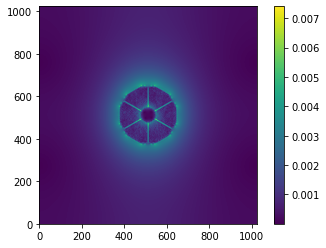

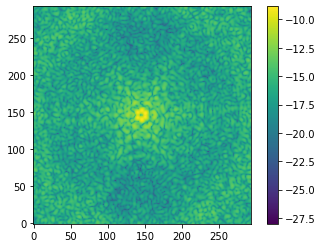

In [5]:
label1_so = 'L_CVC_scao_only_noLT'
psf1_img_so, psf1_off_so, psf1_on_so = add_lighttrap(wf, label1_so, show=False, write=True, **conf)
label1 = 'L_CVC_noLT'
psf1_img, psf1_off, psf1_on = add_lighttrap(wf_err, label1, show=True, write=True, **conf)
plt.figure();plt.imshow(np.log(psf1_on), origin='lower'); plt.colorbar();

### Light trap at start of propagation (downstream of VPM, diverging beam)

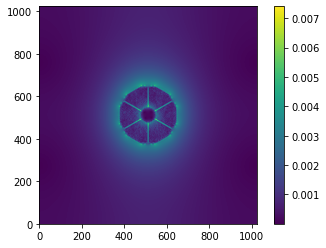

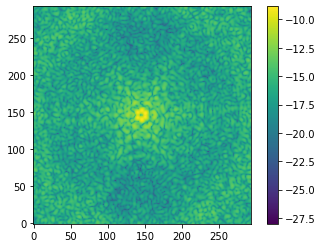

In [6]:
conf2 = dict(conf, lt_dist_start=lt_dist_start, lt_diam_start=lt_diam_start)
label2_so = 'L_CVC_scao_only_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
psf2_img_so, psf2_off_so, psf2_on_so = add_lighttrap(wf, label2_so, show=False, write=True, **conf2)
label2 = 'L_CVC_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
psf2_img, psf2_off, psf2_on = add_lighttrap(wf_err, label2, show=True, write=True, **conf2)
plt.figure();plt.imshow(np.log(psf2_on), origin='lower'); plt.colorbar();

### Light trap at end of propagation (upstream of LS, collimated beam)

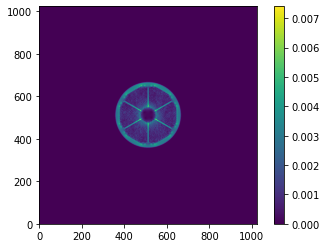

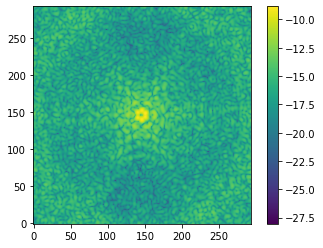

In [7]:
conf3 = dict(conf, lt_dist_end=lt_dist_end_L, lt_diam_end=lt_diam_end_L)
label3_so = 'L_CVC_scao_only_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
psf3_img_so, psf3_off_so, psf3_on_so = add_lighttrap(wf, label3_so, show=False, write=True, **conf3)
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
psf3_img, psf3_off, psf3_on = add_lighttrap(wf_err, label3, show=True, write=True, **conf3)
plt.figure();plt.imshow(np.log(psf3_on), origin='lower'); plt.colorbar();

### HCI mode + light trap

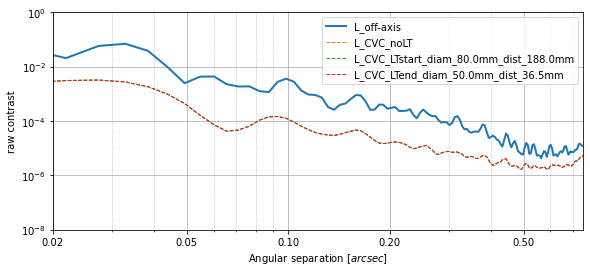

In [8]:
raw_contrast('L_raw_cc_cvc', conf['pscale'], psf1_off, [psf1_off, psf1_on, psf2_on, psf3_on], 
    ['L_off-axis', label1, label2, label3], ymax=1)

### IMG mode + light trap

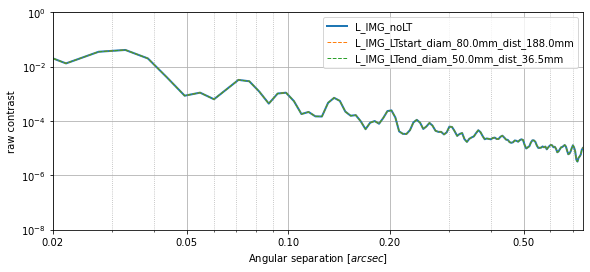

In [9]:
label1_img = 'L_IMG_noLT'
label2_img = 'L_IMG_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
label3_img = 'L_IMG_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
raw_contrast('L_raw_cc_img', conf['pscale'], psf1_img, [psf1_img, psf2_img, psf3_img], 
    [label1_img, label2_img, label3_img], ymax=1)

### show difference between noLT and LTend

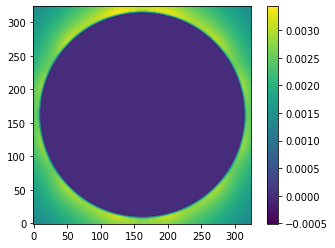

In [10]:
LS1 = fits.getdata(conf['dir_output'] + 'ls_amp_%s.fits'%label1)
LS3 = fits.getdata(conf['dir_output'] + 'ls_amp_%s.fits'%label3)
diff = (LS1-LS3)
fits.writeto(conf['dir_output'] + 'ls_amp_L_CVC_diff_1-3.fits', diff, overwrite=True)
crop = 350
cropped = diff[crop:-crop,crop:-crop]
plt.imshow((cropped), origin='lower');plt.colorbar();

# explore larger light traps

### with current distance = 36.5mm

In [11]:
# lt_dist_end_L = 36.5e-3
# lt_diam_end_L = 60e-3#61e-3
# label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf3 = add_lighttrap(wf_err, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 80e-3#70e-3
# label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf4 = add_lighttrap(wf_err, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 100e-3#79e-3
# label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf5 = add_lighttrap(wf_err, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 120e-3#88e-3
# label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf6 = add_lighttrap(wf_err, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# raw_contrast('L_raw_cc_explore_diam', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6], 
#         [label1, label3, label4, label5, label6], xmin=0.2)

### with "optimized" distance = 58mm

In [12]:
# lt_dist_end_L = 58e-3
# lt_diam_end_L = 61e-3
# label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf3 = add_lighttrap(wf_err, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 70e-3
# label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf4 = add_lighttrap(wf_err, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 79e-3#68e-3
# label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf5 = add_lighttrap(wf_err, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 88e-3#77e-3
# label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf6 = add_lighttrap(wf_err, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# raw_contrast('L_raw_cc_explore_diam', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6], 
#         [label1, label3, label4, label5, label6], xmin=0.2)

# explore longer distances

### with current diameter = 50mm

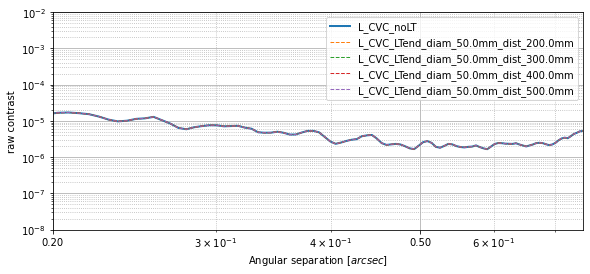

In [13]:
lt_diam_end_L = 50e-3
lt_dist_end_L = 200e-3
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf3 = add_lighttrap(wf_err, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L), show=False)
lt_dist_end_L = 300e-3#46e-3
label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf4 = add_lighttrap(wf_err, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L), show=False)
lt_dist_end_L = 400e-3#52e-3
label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf5 = add_lighttrap(wf_err, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L), show=False)
lt_dist_end_L = 500e-3#58e-3
label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf6 = add_lighttrap(wf_err, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L), show=False)
raw_contrast('L_raw_cc_explore_dist', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6], 
        [label1, label3, label4, label5, label6], xmin=0.2)

### with "optimized" diameter = 88mm

In [14]:
# lt_diam_end_L = 88e-3#77e-3#
# lt_dist_end_L = 40e-3#36.5e-3
# label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf3 = add_lighttrap(wf_err, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_dist_end_L = 46e-3
# label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf4 = add_lighttrap(wf_err, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_dist_end_L = 52e-3
# label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf5 = add_lighttrap(wf_err, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_dist_end_L = 58e-3
# label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf6 = add_lighttrap(wf_err, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# raw_contrast('L_raw_cc_explore_dist', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6], 
#         [label1, label3, label4, label5, label6], xmin=0.2)

# explore combination of diams and distances

In [15]:
# lt_diam_end_L = 75e-3 # LMS: 33e-3/19.9*45
# lt_dist_end_L = 122e-3# LMS: 54e-3/19.9*45
# label2 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf2 = add_lighttrap(wf_err, label2, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 61e-3
# lt_dist_end_L = 40e-3
# label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf3 = add_lighttrap(wf_err, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 70e-3
# lt_dist_end_L = 46e-3
# label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf4 = add_lighttrap(wf_err, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 79e-3
# lt_dist_end_L = 52e-3
# label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf5 = add_lighttrap(wf_err, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# lt_diam_end_L = 88e-3
# lt_dist_end_L = 58e-3
# label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
# _,_,psf6 = add_lighttrap(wf_err, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
#     lt_diam_end=lt_diam_end_L), show=False)
# raw_contrast('L_raw_cc_explore_combi', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6, psf2], 
#         [label1, label3, label4, label5, label6, label2], xmin=0.2)

# 2. N band

In [16]:
conf, wf, wf_err = create_wf('N2', 'CVC')

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=2.4 arcsec (-> ndet=707, 37.9 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)


### No light trap

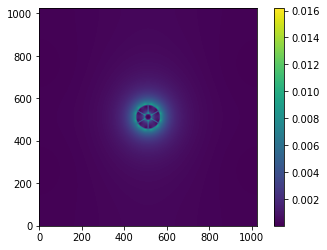

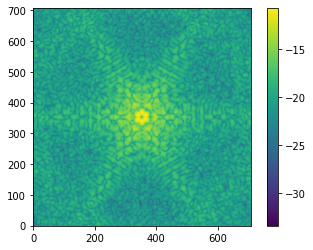

In [17]:
label1_so = 'N_CVC_scao_only_noLT'
psf1_img_so, psf1_off_so, psf1_on_so = add_lighttrap(wf, label1_so, show=False, write=True, **conf)
label1 = 'N_CVC_noLT'
psf1_img, psf1_off, psf1_on = add_lighttrap(wf_err, label1, show=True, write=True, **conf)
plt.figure(); plt.imshow(np.log(psf1_on), origin='lower'); plt.colorbar();

### Light trap before lens (diverging beam)

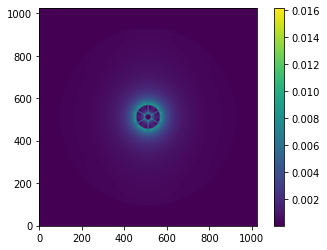

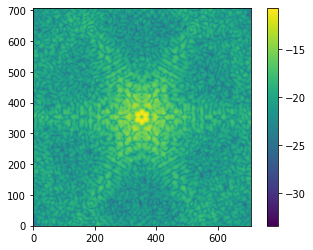

In [18]:
conf2 = dict(conf, lt_dist_start=lt_dist_start, lt_diam_start=lt_diam_start)
label2_so = 'N_CVC_scao_only_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
psf2_img_so, psf2_off_so, psf2_on_so = add_lighttrap(wf, label2_so, show=False, write=True, **conf2)
label2 = 'N_CVC_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
psf2_img, psf2_off, psf2_on = add_lighttrap(wf_err, label2, show=True, write=True, **conf2)
plt.figure(); plt.imshow(np.log(psf2_on), origin='lower'); plt.colorbar();

### Light trap after lens (collimated beam)

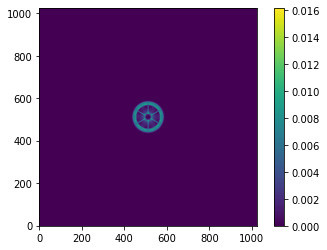

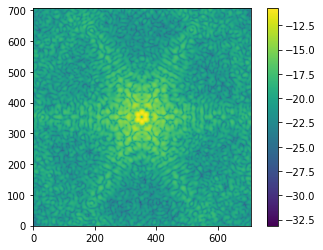

In [19]:
conf3 = dict(conf, lt_dist_end=lt_dist_end_N, lt_diam_end=lt_diam_end_N)
label3_so = 'N_CVC_scao_only_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_N*1e3, lt_dist_end_N*1e3)
psf3_img_so, psf3_off_so, psf3_on_so = add_lighttrap(wf, label3_so, show=False, write=True, **conf2)
label3 = 'N_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_N*1e3, lt_dist_end_N*1e3)
psf3_img, psf3_off, psf3_on = add_lighttrap(wf_err, label3, show=True, write=True, **conf3)
plt.figure(); plt.imshow(np.log(psf3_on), origin='lower'); plt.colorbar();

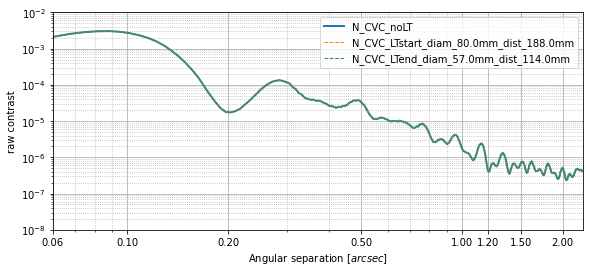

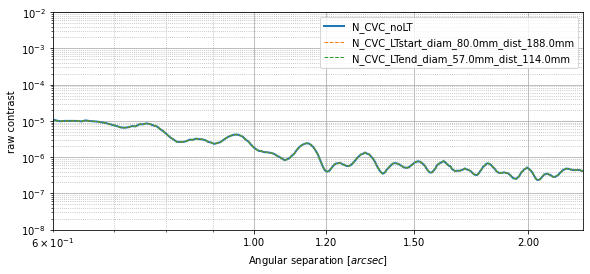

In [20]:
raw_contrast('N_raw_cc', conf['pscale'], psf1_off, [psf1_on, psf2_on, psf3_on], [label1, label2, label3], band='N')
raw_contrast('N_raw_cc', conf['pscale'], psf1_off, [psf1_on, psf2_on, psf3_on], [label1, label2, label3], band='N', xmin=0.6)